In [51]:
# Stage 5 --- Improving the model with Hyperparameter Tuning --- 
# Use Hyperparameter tuning to find the best parameters for our model 

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
# Set random seeds for reproducibility
import tensorflow as tf
import numpy as np
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

In [5]:
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [6]:
X_train = X_train.values
y_train = y_train.values

In [7]:
X_test = X_test.values
y_test = y_test.values

In [8]:
# Use hyperparameter tuning to optimise parameters in the model

In [9]:
# Define function to create a model in order to run keras classifier

In [10]:
def create_model(neurons1=136, neurons2=68, optimizer='adam', activation='relu', dropout_rate=0.0, add_layer = False, neurons3=34):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=68, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dropout(dropout_rate))
    if add_layer:
        model.add(Dense(neurons3, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [12]:
# Specify the parameter grid: 
# - 3 different amounts of neurons in the first layer 
# - 2 in the second 
# - an extra layer 
# - 3 different drop out rates
# - two different batch sizes

In [13]:
param_grid = { 
    'neurons1': [68, 136],
    'neurons2': [68, 34],
    'add_layer': [False, True],
    'neurons3': [34],
    'dropout_rate': [0.0, 0.5],
    'batch_size': [64,128]
}
    

In [14]:
# Specify gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [15]:
X = X_train
y = y_train

In [16]:
grid_result = grid.fit(X, y)

In [17]:
# Evaluate results of gridsearch

In [18]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.889074464639028 using {'add_layer': False, 'batch_size': 64, 'dropout_rate': 0.5, 'neurons1': 68, 'neurons2': 68, 'neurons3': 34}


In [19]:
grid_result.best_params_

{'add_layer': False,
 'batch_size': 64,
 'dropout_rate': 0.5,
 'neurons1': 68,
 'neurons2': 68,
 'neurons3': 34}

In [20]:
# The grid search has selected mostly the same model as the first, just with an added hidden layer of 34 neurons.

In [21]:
# Train the model on entire data set and evaluate performance
best_model = create_model(neurons1=68, neurons2=68, optimizer='adam', activation='relu', dropout_rate=0.5, add_layer = False, neurons3=34)

In [22]:
best_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

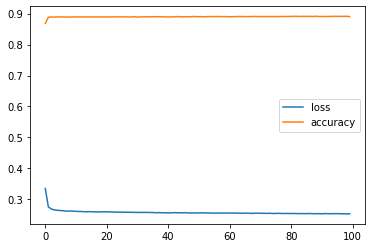

In [23]:
losses = pd.DataFrame(best_model.history.history)
losses.plot()

In [24]:
predictions_best = best_model.predict_classes(X_test)
print(classification_report(y_test,predictions_best))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.99      0.44      0.60     62102
           1       0.88      1.00      0.93    254073

    accuracy                           0.89    316175
   macro avg       0.93      0.72      0.77    316175
weighted avg       0.90      0.89      0.87    316175



In [ ]:
#  -- Evaluation -- 
# - Interestingly this model performs as well as our first model by f1-score and accuracy but with quite a different structure.  
# - It seems strange that the hypertuned model hasn't come out with better accuracy overall especially when our original model was still one of the possible combinations from the parameter grid.
# - However it actually is not uncommon to get equal or lower performance on a different hypertuned model for various reasons.

# - One reason is that during grid search, the model performance is averaged over the cross-validation folds. This might not perfectly align with the performance on the holdout test set.
# - Secondly, the grid search might find a model that performs well on the cross-validation sets but overfits when trained on the entire training set.
# - Thirdly, the grid search might have found a local optimum that doesn't generalize as well as the initial model.